Epoch 1/50
13770/13770 [==============================] - 32s 2ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 2/50
13770/13770 [==============================] - 32s 2ms/step - loss: 0.0011 - val_loss: 9.2301e-04
Epoch 3/50
13770/13770 [==============================] - 42s 3ms/step - loss: 8.9667e-04 - val_loss: 8.6880e-04
Epoch 4/50
13770/13770 [==============================] - 31s 2ms/step - loss: 8.4980e-04 - val_loss: 8.4259e-04
Epoch 5/50
13770/13770 [==============================] - 32s 2ms/step - loss: 8.1652e-04 - val_loss: 8.1236e-04
Epoch 6/50
13770/13770 [==============================] - 32s 2ms/step - loss: 7.8704e-04 - val_loss: 7.9183e-04
Epoch 7/50
13770/13770 [==============================] - 33s 2ms/step - loss: 7.6937e-04 - val_loss: 7.4335e-04
Epoch 8/50
13770/13770 [==============================] - 31s 2ms/step - loss: 7.4646e-04 - val_loss: 7.4975e-04
Epoch 9/50
13770/13770 [==============================] - 32s 2ms/step - loss: 7.2194e-04 - val_loss: 7.0921

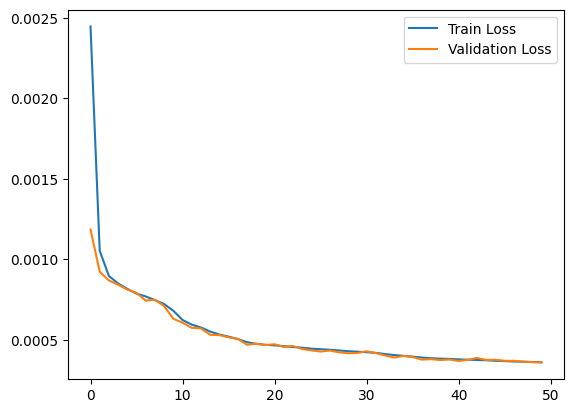

13894/13894 [==============================] - 21s 2ms/step
Threshold: 0.10750373239914315


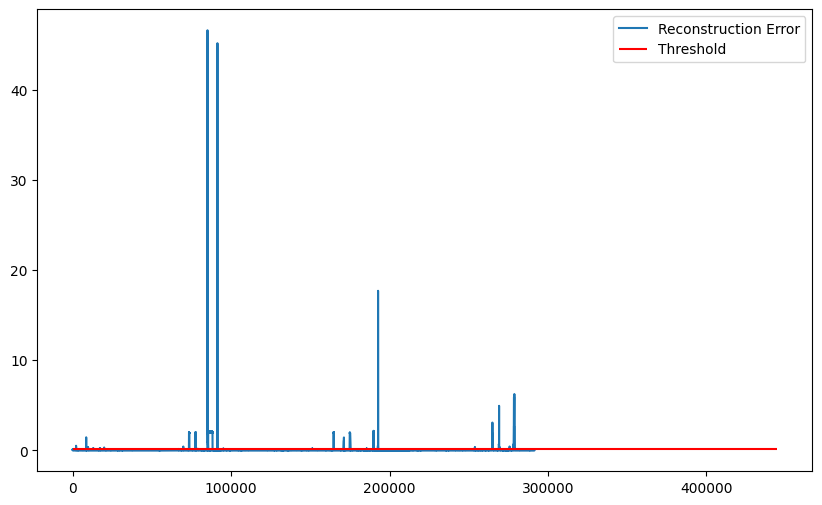

[[413918  13155]
 [  8452   9075]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    427073
           1       0.41      0.52      0.46     17527

    accuracy                           0.95    444600
   macro avg       0.69      0.74      0.72    444600
weighted avg       0.96      0.95      0.95    444600



In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from pathlib import Path

# 데이터 읽기
TRAIN_FILES = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/train/").glob("*.csv")])
TEST_FILES = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/test/").glob("*.csv")])

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_FILES)
TEST_DF_RAW = dataframe_from_csvs(TEST_FILES)

# 공격 레이블 제거
ATTACK_DF = TEST_DF_RAW['attack']
DROP_FIELD = ["time", "attack_P1", "attack_P2", "attack_P3", "attack"]
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD)
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

def normalize(df, TAG_MIN, TAG_MAX):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

# Min-Max 정규화
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX).ewm(alpha=0.9).mean()

# DataFrame 중 1초과, 0미만 값이 있는지 확인
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

boundary_check(TRAIN_DF)

# 오토인코더 모델 정의
input_dim = TRAIN_DF.shape[1]
hidden_dim = 64
code_dim = 16

input_layer = Input(shape=(input_dim,))
hidden_1 = Dense(hidden_dim, activation='relu')(input_layer)
code = Dense(code_dim, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_dim, activation='relu')(code)
output_layer = Dense(input_dim, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 데이터셋을 훈련 및 검증으로 분리
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(TRAIN_DF, test_size=0.2, random_state=42)

# 오토인코더 모델 훈련
history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(val_data, val_data),
                          verbose=1)

# 훈련 과정 시각화 (옵션)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 테스트 데이터셋 정규화 및 예측
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX).ewm(alpha=0.9).mean()
reconstructed = autoencoder.predict(TEST_DF)

# 재구성 오차 계산
mse = np.mean(np.power(TEST_DF - reconstructed, 2), axis=1)

# 임계값 설정 (훈련 데이터에서의 95번째 백분위수 사용)
threshold = np.percentile(mse, 95)
print(f'Threshold: {threshold}')

# 이상 탐지
anomalies = mse > threshold
anomalies = anomalies.astype(int)  # 이진형으로 변환

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(mse, label='Reconstruction Error')
plt.hlines(threshold, xmin=0, xmax=len(mse), colors='r', label='Threshold')
plt.legend()
plt.show()

# 공격 레이블과 비교
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(ATTACK_DF, anomalies))
print(classification_report(ATTACK_DF, anomalies))